In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stiffODE

100%|█████████▉| 12.56630641619422/12.566370614359172 [00:01<00:00,  7.16it/s] 
  0%|          | 0.0019309999999999369/12.566370614359172 [00:00<22:30, 107.49s/it]

17,996.000000 steps accepted, 0.000000 rejected


100%|█████████▉| 12.56636825174527/12.566370614359172 [06:08<00:00, 29.30s/it]     


3,815,413.000000 steps accepted, 0.000000 rejected


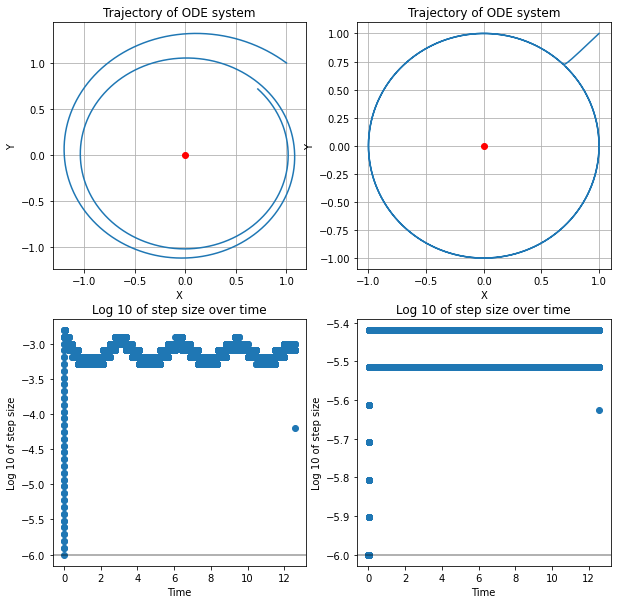

In [2]:

def stableCircular(t, y, alpha=1.0):
    
    norm = np.linalg.norm(y,2)
    
    x = -alpha * (norm-1)
    
    f = np.array([
        [x, -1],
        [1, x]
    ]) @ y
    
    df1 = alpha*(norm**2 + y[0]**2)
    df2 = 1+alpha*y[0]*y[1]
    df3 = alpha*(norm**2 + y[1]**2)
    
    DF = np.array([
        [df1,df2],
        [df2,df3]
    ])/(-norm)
    
    return f, DF 
    




alphas = [0.25, 200]

# initial position
y0 = [1,1]

# Step size controls
dtmax = 1
dtmin = 1.0e-6

# Tolerance
tol = 0.001

tstart = 0
tend = 4*np.pi

# Euclidean norm
norm = np.linalg.norm

fig, axs = plt.subplots(2, 2, figsize=(10,10))

for i in range(2):
    
    a = alphas[i]
    
    xs, ts, dts, _, _, stepsAccepted, stepsRejected = stiffODE.SolveStiffODE (
        y0=y0,
        dyf = lambda t,y: stableCircular(t,y,a),
        norm = norm,
        tstart = tstart,
        tend = tend,
        dtmin = dtmin,
        dtmax = dtmax,
        tol = tol,
    )
    
    # Plot the center, very aesthetic
    axs[0,i].plot(0,0,'ro')
    axs[0,i].plot(
        xs[:,0],
        xs[:,1]
    )
    axs[0,i].set_title('Trajectory of ODE system')
    axs[0,i].set_xlabel('X')
    axs[0,i].set_ylabel('Y')
    axs[0,i].grid()
    

    
    axs[1,i].axhline( np.log10(dtmin), color='black', alpha=0.4)
    axs[1,i].set_title('Log 10 of step size over time')
    axs[1,i].set_xlabel('Time')
    axs[1,i].set_ylabel('Log 10 of step size')
    axs[1,i].scatter(
        ts[:-1],
        np.log10(dts)
    )

    print('{0:,f} steps accepted, {1:,f} rejected'.format(
        stepsAccepted,
        stepsRejected
    ))
    
    
plt.savefig('spiral.png')
plt.show()

In [3]:
def belousov_zhabotinsky(t, yin):
    alpha = 77.27
    beta = 8.375e-6
    gamma = 0.161
    
    x,y,z = yin
    
    f = np.array([
        
        alpha*(y-x*y+x-beta*x**2),
        
        (-y-x*y+z)/alpha,
        
        gamma*(x-z)
    ])
    
    
    
    d11 = alpha*(1-2*beta*x-y)
    d12 = alpha*(1-x)
    d13 = 0
    
    d21 = -y/alpha
    d22 = (-1-x)/alpha
    d23 = 1/alpha
    
    d31 = gamma
    d32 = 0
    d33 = -gamma
    
    Df = np.array([
        [d11,d12,d13,],
        [d21,d22,d23,],
        [d31,d32,d33,],
    ])
    
    return f, Df

def bz_norm ( yin ):
    x,y,z = yin
    n = np.abs(x)/1.25e5 + np.abs(y)/1800 + np.abs(z)/3.0e4
    return n


In [4]:
tol = [1.0e-3, 1.0e-4, 1.0e-6]

# initial position
y0 = [4,1.1,4]

# Step size controls
dtmax = 1
dtmin = 1.0e-6

tstart = 0
tend = 700


results = list(map(
    lambda tol: stiffODE.SolveStiffODE (
        y0=y0,
        dyf = belousov_zhabotinsky,
        norm = bz_norm,
        tstart = tstart,
        tend = tend,
        dtmin = dtmin,
        dtmax = dtmax,
        tol = tol,
    ),
    tol
))


100%|█████████▉| 699.9999899986524/700 [16:58<00:00,  1.46s/it]   
100%|█████████▉| 699.9999887413283/700 [17:45<00:00,  1.52s/it]   
100%|█████████▉| 699.9999868200398/700 [23:53<00:00,  2.05s/it]     


In [7]:

pd.DataFrame(
    data=list(map(
        lambda x: (x[-2], x[-1]),
        results
    )),
    columns=['Steps Accepted','Steps Rejected'],
    index=tol,
)

,Steps Accepted,Steps Rejected
0.001000,9941552,1291061
0.000100,10496500,1295753
0.000001,14750351,1153379


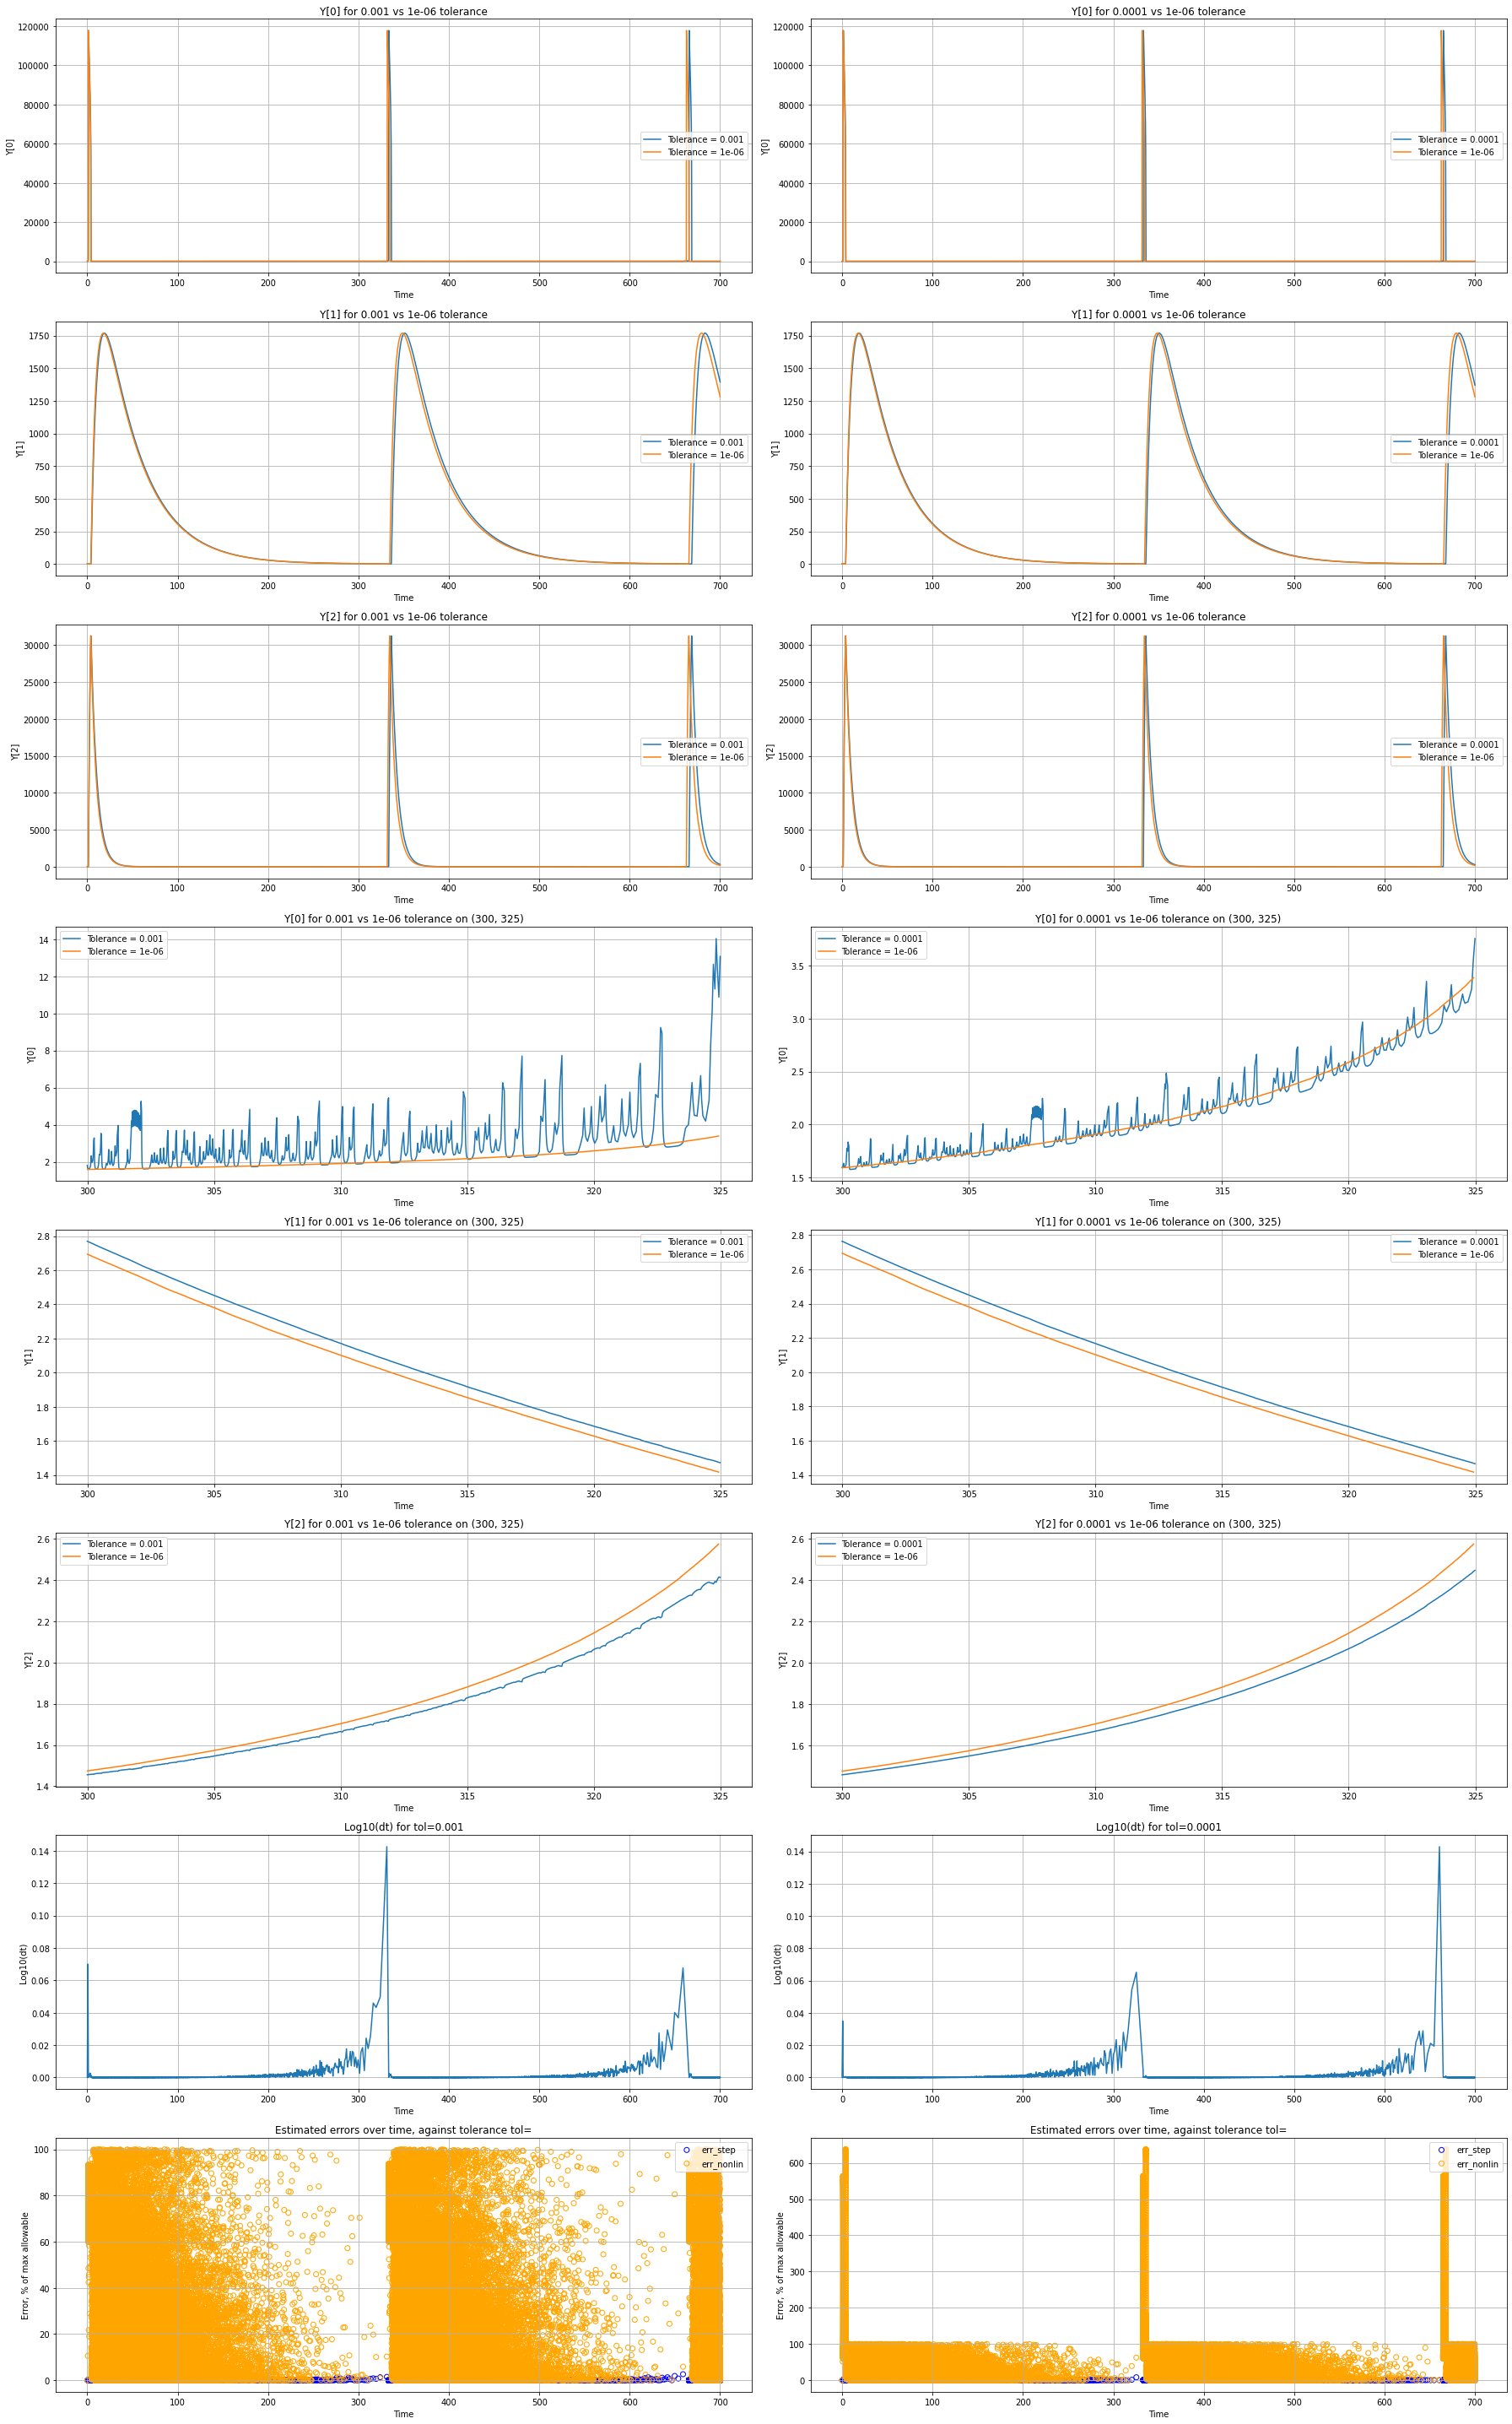

In [14]:
fig, axs = plt.subplots(8, 2, figsize=(25,40))
stepsize = 100


for i, t in enumerate(tol[:2]):
    
    xs, ts, dts, err_step, err_nonlin, stepsAccepted, stepsRejected = results[i]
    
    # Plot the center, very aesthetic
    
    for j in range(3):
        axs[j,i].plot(
            ts[0:-1:stepsize],
            xs[0:-1:stepsize,j],
            label='Tolerance = {}'.format(t),
        )
        axs[j,i].plot(
            results[-1][1][0:-1:stepsize],
            results[-1][0][0:-1:stepsize,j],
            label='Tolerance = {}'.format(tol[-1]),
        )
        axs[j,i].set_title('Y[{0}] for {1} vs {2} tolerance'.format(
            j,
            t,
            tol[-1]
        ))
        axs[j,i].set_ylabel('Y[{0}]'.format(j))
        axs[j,i].set_xlabel('Time')
        axs[j,i].grid()
        axs[j,i].legend()
        
        
        
        
        ami = np.argmin(
            np.where(
                ts < 300,
                700,
                ts
            )
        )-1
        ama = np.argmax(
            np.where(
                ts > 325,
                0,
                ts
            )
        )+1
        
        
        bmi = np.argmin(
            np.where(
                results[-1][1] < 300,
                700,
                results[-1][1]
            )
        )-1
        bma = np.argmax(
            np.where(
                results[-1][1] > 325,
                0,
                results[-1][1]
            )
        )+1
        
        
        
        axs[3+j,i].plot(
            ts[ami:ama],
            xs[ami:ama,j],
            label='Tolerance = {}'.format(t),
        )
        axs[3+j,i].plot(
            results[-1][1][bmi:bma],
            results[-1][0][bmi:bma,j],
            label='Tolerance = {}'.format(tol[-1]),
        )
        axs[3+j,i].set_title('Y[{0}] for {1} vs {2} tolerance on (300, 325)'.format(
            j,
            t,
            tol[-1]
        ))
        axs[3+j,i].set_ylabel('Y[{0}]'.format(j))
        axs[3+j,i].set_xlabel('Time')
        axs[3+j,i].grid()
        axs[3+j,i].legend()
    
    
    
    
    j = 6
    axs[j,i].plot(
        ts[0:-2:stepsize],
        dts[0:-1:stepsize]
    )
    
    axs[j,i].set_title('Log10(dt) for tol={}'.format( t, ))
    axs[j,i].set_ylabel('Log10(dt)'.format(j))
    axs[j,i].set_xlabel('Time')
    axs[j,i].grid()
    
    
    
    j = 7
    axs[j,i].scatter(
        ts[0:-2:stepsize],
        100 * err_step[0:-1:stepsize] / t,
        label='err_step',
        facecolors='none',
        edgecolors='blue',
    )
    axs[j,i].scatter(
        ts[0:-2:stepsize],
        100 * err_nonlin[0:-1:stepsize] / t,
        label='err_nonlin',
        facecolors='none',
        edgecolors='orange',
    )
    
    axs[j,i].set_title('Estimated errors over time, against tolerance tol='.format( t, ))
    axs[j,i].set_ylabel('Error, % of max allowable'.format(j))
    axs[j,i].set_xlabel('Time')
    axs[j,i].legend()
    axs[j,i].grid()
    
    
    
    
    
plt.tight_layout()
plt.savefig('chemistry.png')
plt.show()